### Find note counts for all files

In [3]:
import os
from dotenv import load_dotenv
import note_seq

# Load environment variables
load_dotenv()

# Paths
GUITARSET_PATH = os.getenv("GUITARSET_PATH")
GUITARSET_MIDI_PATH = os.path.join(GUITARSET_PATH, "midi")

# Initialize dictionary
midi_note_counts = {}

# Loop through all MIDI files in the folder
for filename in os.listdir(GUITARSET_MIDI_PATH):
    if filename.endswith(".mid") or filename.endswith(".midi"):
        midi_path = os.path.join(GUITARSET_MIDI_PATH, filename)
        file_key = os.path.splitext(filename)[0]  # Remove extension
        
        try:
            ns = note_seq.midi_file_to_note_sequence(midi_path)
            num_notes = len(ns.notes)
            midi_note_counts[file_key] = num_notes
        except Exception as e:
            print(f"Failed to parse {filename}: {e}")

# Example: print the number of notes for the first few files
for i, (fname, count) in enumerate(midi_note_counts.items()):
    print(f"{fname}: {count} notes")
    if i >= 4:
        break


/opt/anaconda3/lib/python3.12/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


03_SS1-100-C#_comp_mic: 368 notes
04_Jazz2-110-Bb_solo_mic: 78 notes
03_Rock1-90-C#_comp_mic: 204 notes
03_Rock2-142-D_solo_mic: 88 notes
01_SS3-98-C_comp_mic: 502 notes


### Plot scores vs. note count

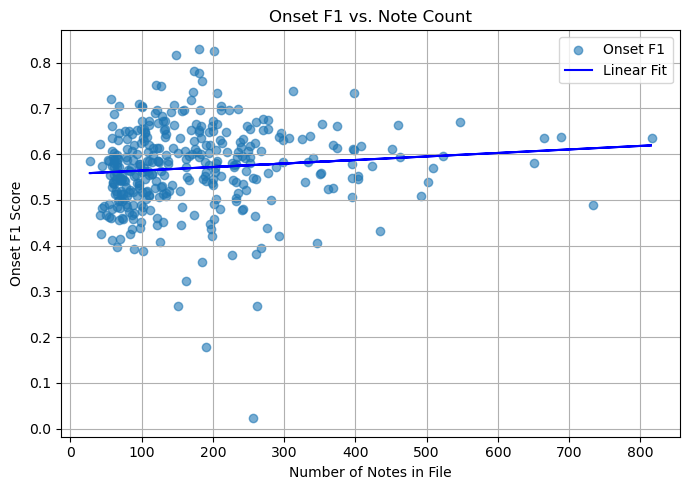

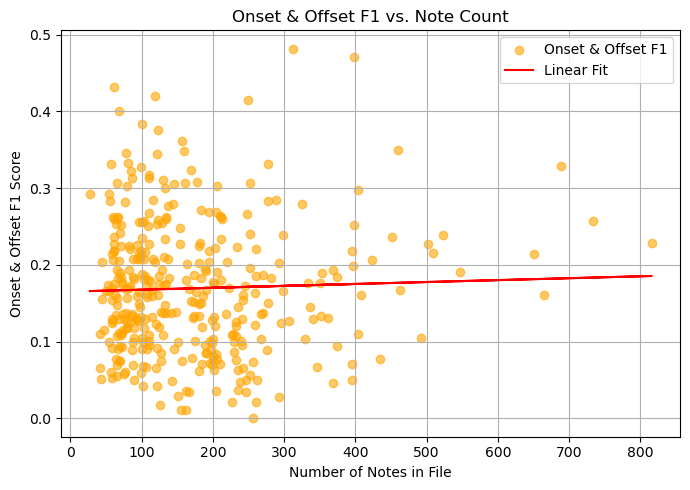

In [4]:
import os
import re
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Paths
RESULTS_PATH = "results/results.txt"
OUTPUT_DIR = "results/plots"

# Parse results
f1_scores = {}

with open(RESULTS_PATH, "r") as f:
    lines = f.readlines()

filename = None
for line in lines:
    line = line.strip()
    if line.startswith("Scores for file"):
        match = re.search(r"Scores for file (.+\.wav)", line)
        if match:
            filename = os.path.splitext(match.group(1))[0]
            f1_scores[filename] = {}
    elif line.startswith("Onset F1:") and filename:
        f1_scores[filename]["onset"] = float(line.split(":")[1].strip())
    elif line.startswith("Onset & Offset F1:") and filename:
        f1_scores[filename]["onset_offset"] = float(line.split(":")[1].strip())

# Combine data
combined = []
for fname, scores in f1_scores.items():
    if fname in midi_note_counts:
        combined.append((midi_note_counts[fname], scores.get("onset", 0), scores.get("onset_offset", 0)))

# Unpack
note_counts = [x[0] for x in combined]
onset_f1s = [x[1] for x in combined]
onset_offset_f1s = [x[2] for x in combined]

# Regression: Onset F1
slope_onset, intercept_onset, *_ = linregress(note_counts, onset_f1s)
line_onset = [slope_onset * x + intercept_onset for x in note_counts]

# Regression: Onset & Offset F1
slope_onset_offset, intercept_onset_offset, *_ = linregress(note_counts, onset_offset_f1s)
line_onset_offset = [slope_onset_offset * x + intercept_onset_offset for x in note_counts]

# Ensure results folder exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plot 1: Onset F1
plt.figure(figsize=(7, 5))
plt.scatter(note_counts, onset_f1s, alpha=0.6, label="Onset F1")
plt.plot(note_counts, line_onset, color='blue', label="Linear Fit")
plt.title("Onset F1 vs. Note Count")
plt.xlabel("Number of Notes in File")
plt.ylabel("Onset F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "onset_f1_vs_note_count.png"), dpi=300)
plt.show()

# Plot 2: Onset & Offset F1
plt.figure(figsize=(7, 5))
plt.scatter(note_counts, onset_offset_f1s, alpha=0.6, color='orange', label="Onset & Offset F1")
plt.plot(note_counts, line_onset_offset, color='red', label="Linear Fit")
plt.title("Onset & Offset F1 vs. Note Count")
plt.xlabel("Number of Notes in File")
plt.ylabel("Onset & Offset F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "onset_offset_f1_vs_note_count.png"), dpi=300)
plt.show()


### Find best and worst performing files

In [5]:
# Find the best and worst performing files for Onset F1
best_onset_f1_file = max(f1_scores, key=lambda x: f1_scores[x].get("onset", 0))
worst_onset_f1_file = min(f1_scores, key=lambda x: f1_scores[x].get("onset", 0))

# Find the best and worst performing files for Onset & Offset F1
best_onset_offset_f1_file = max(f1_scores, key=lambda x: f1_scores[x].get("onset_offset", 0))
worst_onset_offset_f1_file = min(f1_scores, key=lambda x: f1_scores[x].get("onset_offset", 0))

# Print the results
print(f"Best Onset F1: {best_onset_f1_file} with {f1_scores[best_onset_f1_file].get('onset', 0)} F1")
print(f"Worst Onset F1: {worst_onset_f1_file} with {f1_scores[worst_onset_f1_file].get('onset', 0)} F1")

print(f"Best Onset & Offset F1: {best_onset_offset_f1_file} with {f1_scores[best_onset_offset_f1_file].get('onset_offset', 0)} F1")
print(f"Worst Onset & Offset F1: {worst_onset_offset_f1_file} with {f1_scores[worst_onset_offset_f1_file].get('onset_offset', 0)} F1")


Best Onset F1: 05_BN3-119-G_comp_mic with 0.8305 F1
Worst Onset F1: 02_Funk2-108-Eb_comp_mic with 0.0228 F1
Best Onset & Offset F1: 05_Rock1-130-A_comp_mic with 0.4815 F1
Worst Onset & Offset F1: 02_Funk2-108-Eb_comp_mic with 0.0 F1


### Function for plotting piano roll

In [10]:
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

def plot_piano_roll(midi_path, output_path, title='Piano Roll', fs=100):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    piano_roll = midi_data.get_piano_roll(fs=fs)

    # Binarize: all non-zero velocities become 1
    piano_roll[piano_roll > 0] = 1

    # Find pitch range with notes
    nonzero_pitch_indices = np.where(piano_roll.sum(axis=1) > 0)[0]
    if len(nonzero_pitch_indices) == 0:
        return

    min_pitch = max(nonzero_pitch_indices[0] - 5, 0)
    max_pitch = min(nonzero_pitch_indices[-1] + 5, piano_roll.shape[0] - 1)

    # Crop to padded pitch range
    cropped_roll = piano_roll[min_pitch:max_pitch + 1, :]

    # Use consistent solid blue from "Blues" colormap
    blue = plt.get_cmap('Blues')(0.8)  # adjust this value (0.0–1.0) for lighter/darker blue
    white_blue = ListedColormap([[1, 1, 1, 1], blue])  # white for 0, blue for 1

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
    ax.imshow(cropped_roll, aspect='auto', origin='lower', cmap=white_blue, interpolation='nearest')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Time (frames)', fontsize=16)
    ax.set_ylabel('MIDI Note', fontsize=16)

    yticks = np.linspace(0, max_pitch - min_pitch, 10)
    ytick_labels = np.linspace(min_pitch, max_pitch, 10, dtype=int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    ax.set_facecolor('white')

    plt.tight_layout()
    plt.savefig(output_path, dpi=150)
    plt.show()
    plt.close()


### Plot ground truth and predicted piano rolls - Best Onset F1

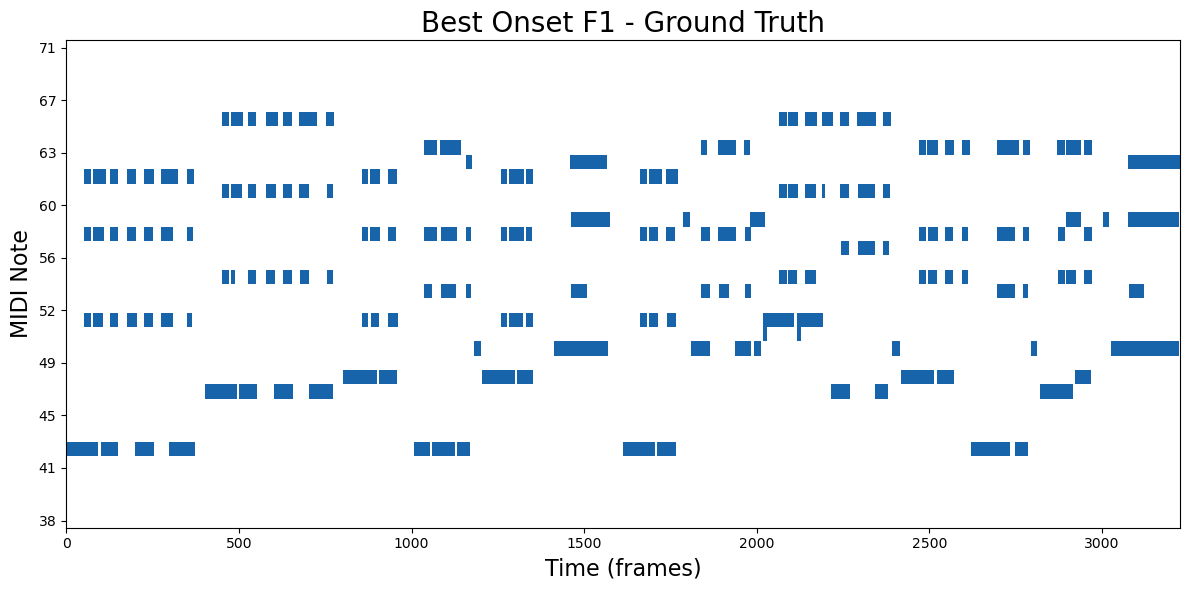

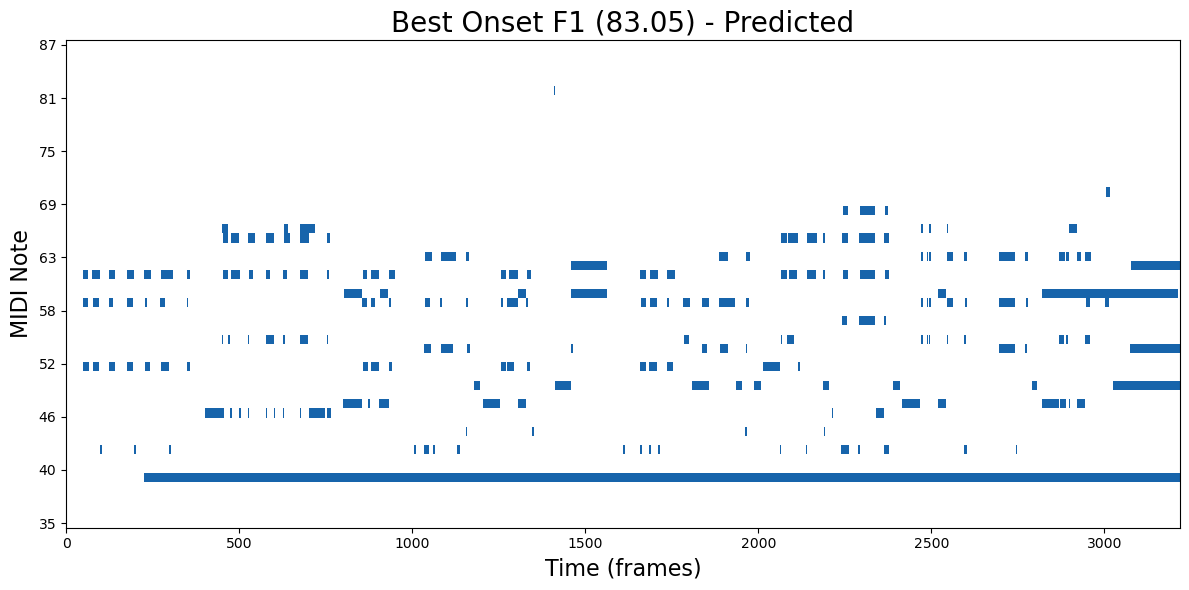

In [11]:
midi_path = GUITARSET_MIDI_PATH + "/" + best_onset_f1_file + ".midi"
predicted_midi_path = "results/predicted_midi/" + best_onset_f1_file + "_pred.midi"

os.makedirs("results/piano_rolls", exist_ok=True)
ground_truth_img = "results/piano_rolls/best_onset_f1_ground_truth.png"
predicted_img = "results/piano_rolls/best_onset_f1_predicted.png"

plot_piano_roll(midi_path, ground_truth_img, title='Best Onset F1 - Ground Truth')
plot_piano_roll(predicted_midi_path, predicted_img, title=f'Best Onset F1 ({f1_scores[best_onset_f1_file].get('onset', 0) * 100}) - Predicted')

### Plot ground truth and predicted piano rolls - Best Onset & Offset F1

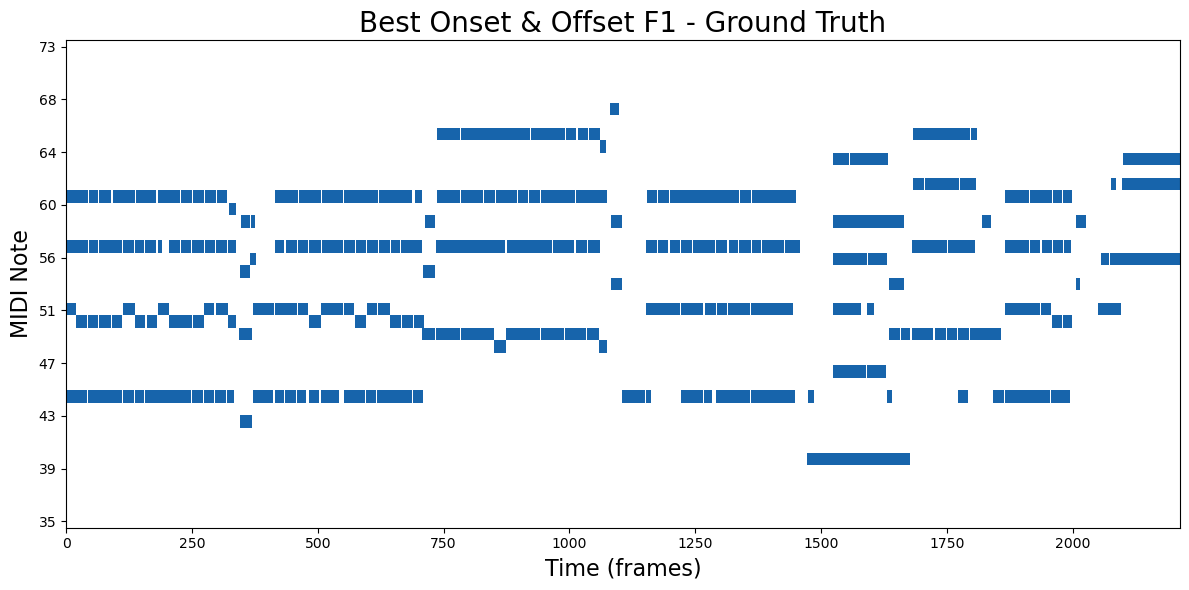

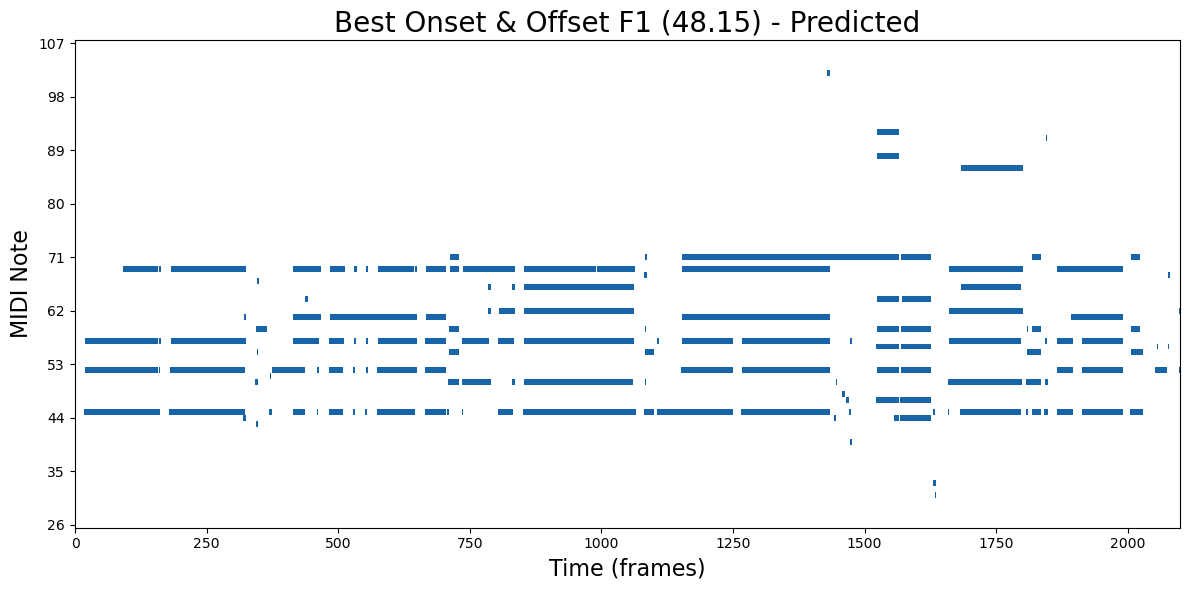

In [12]:
midi_path = GUITARSET_MIDI_PATH + "/" + best_onset_offset_f1_file + ".midi"
predicted_midi_path = "results/predicted_midi/" + best_onset_offset_f1_file + "_pred.midi"

os.makedirs("results/piano_rolls", exist_ok=True)
ground_truth_img = "results/piano_rolls/best_onset_offset_f1_ground_truth.png"
predicted_img = "results/piano_rolls/best_onset_offset_f1_predicted.png"

plot_piano_roll(midi_path, ground_truth_img, title='Best Onset & Offset F1 - Ground Truth')
plot_piano_roll(predicted_midi_path, predicted_img, title=f'Best Onset & Offset F1 ({f1_scores[best_onset_offset_f1_file].get('onset_offset', 0) * 100}) - Predicted')

### Calculate average note sustain

In [13]:
import os
from dotenv import load_dotenv
import note_seq

# Load environment variables
load_dotenv()

# Paths
GUITARSET_PATH = os.getenv("GUITARSET_PATH")
GUITARSET_MIDI_PATH = os.path.join(GUITARSET_PATH, "midi")

# Initialize dictionary
midi_note_sustain = {}

# Loop through all MIDI files in the folder
for filename in os.listdir(GUITARSET_MIDI_PATH):
    if filename.endswith(".mid") or filename.endswith(".midi"):
        midi_path = os.path.join(GUITARSET_MIDI_PATH, filename)
        file_key = os.path.splitext(filename)[0]  # Remove extension
        
        try:
            # Try to parse MIDI file into a NoteSequence
            ns = note_seq.midi_file_to_note_sequence(midi_path)

            # Initialize variables
            total_sustain_time = 0
            num_notes = len(ns.notes)
            
            # Calculate total sustain time for all notes
            for note in ns.notes:
                sustain_time = note.end_time - note.start_time
                total_sustain_time += sustain_time
            
            # Calculate average sustain time
            if num_notes > 0:
                average_sustain_time = total_sustain_time / num_notes
                midi_note_sustain[file_key] = average_sustain_time
            else:
                print(f"No notes found in {filename}. Skipping file.")
        
        except Exception as e:
            print(f"Failed to parse {filename}: {e}")

# Example: print the average sustain time for the first few files
for i, (fname, sustain) in enumerate(midi_note_sustain.items()):
    print(f"{fname}: {sustain:.3f} seconds")
    if i >= 4:
        break


03_SS1-100-C#_comp_mic: 0.281 seconds
04_Jazz2-110-Bb_solo_mic: 0.317 seconds
03_Rock1-90-C#_comp_mic: 0.392 seconds
03_Rock2-142-D_solo_mic: 0.217 seconds
01_SS3-98-C_comp_mic: 0.376 seconds


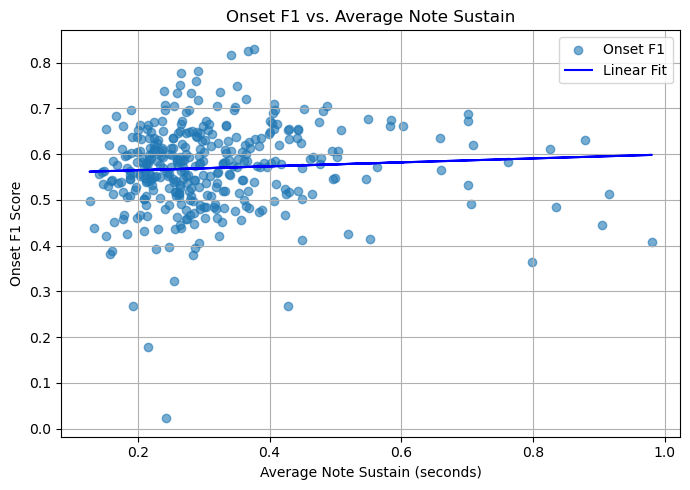

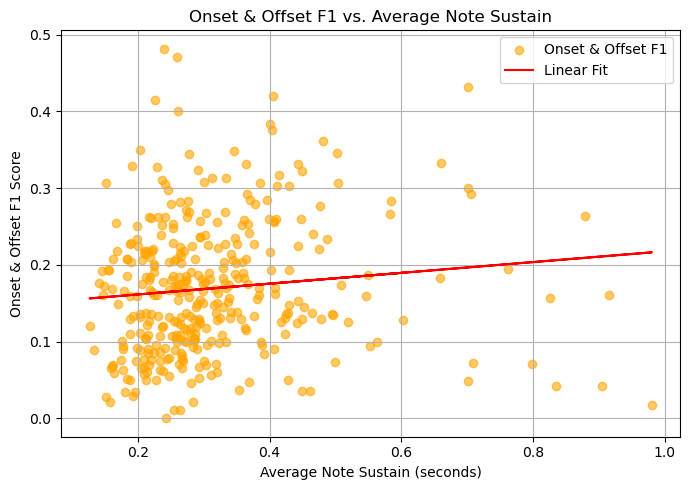

In [ ]:
import os
import re
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Paths
RESULTS_PATH = "results/results.txt"
OUTPUT_DIR = "results/plots"

# Parse results
f1_scores = {}

with open(RESULTS_PATH, "r") as f:
    lines = f.readlines()

filename = None
for line in lines:
    line = line.strip()
    if line.startswith("Scores for file"):
        match = re.search(r"Scores for file (.+\.wav)", line)
        if match:
            filename = os.path.splitext(match.group(1))[0]
            f1_scores[filename] = {}
    elif line.startswith("Onset F1:") and filename:
        f1_scores[filename]["onset"] = float(line.split(":")[1].strip())
    elif line.startswith("Onset & Offset F1:") and filename:
        f1_scores[filename]["onset_offset"] = float(line.split(":")[1].strip())

# Combine data
combined = []
for fname, scores in f1_scores.items():
    if fname in midi_note_sustain:
        combined.append((midi_note_sustain[fname], scores.get("onset", 0), scores.get("onset_offset", 0)))

# Unpack
sustains = [x[0] for x in combined]
onset_f1s = [x[1] for x in combined]
onset_offset_f1s = [x[2] for x in combined]

# Regression: Onset F1
slope_onset, intercept_onset, *_ = linregress(sustains, onset_f1s)
line_onset = [slope_onset * x + intercept_onset for x in sustains]

# Regression: Onset & Offset F1
slope_onset_offset, intercept_onset_offset, *_ = linregress(sustains, onset_offset_f1s)
line_onset_offset = [slope_onset_offset * x + intercept_onset_offset for x in sustains]

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plot 1: Onset F1
plt.figure(figsize=(7, 5))
plt.scatter(sustains, onset_f1s, alpha=0.6, label="Onset F1")
plt.plot(sustains, line_onset, color='blue', label="Linear Fit")
plt.title("Onset F1 vs. Average Note Sustain")
plt.xlabel("Average Note Sustain (seconds)")
plt.ylabel("Onset F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "onset_f1_vs_sustain.png"), dpi=300)
plt.show()

# Plot 2: Onset & Offset F1
plt.figure(figsize=(7, 5))
plt.scatter(sustains, onset_offset_f1s, alpha=0.6, color='orange', label="Onset & Offset F1")
plt.plot(sustains, line_onset_offset, color='red', label="Linear Fit")
plt.title("Onset & Offset F1 vs. Average Note Sustain")
plt.xlabel("Average Note Sustain (seconds)")
plt.ylabel("Onset & Offset F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "onset_offset_f1_vs_sustain.png"), dpi=300)
plt.show()


### Evaluating a more monophonic excerpt

Monophonic File: 03_BN3-119-G_solo_mic
Onset F1: 0.4852
Onset & Offset F1: 0.118


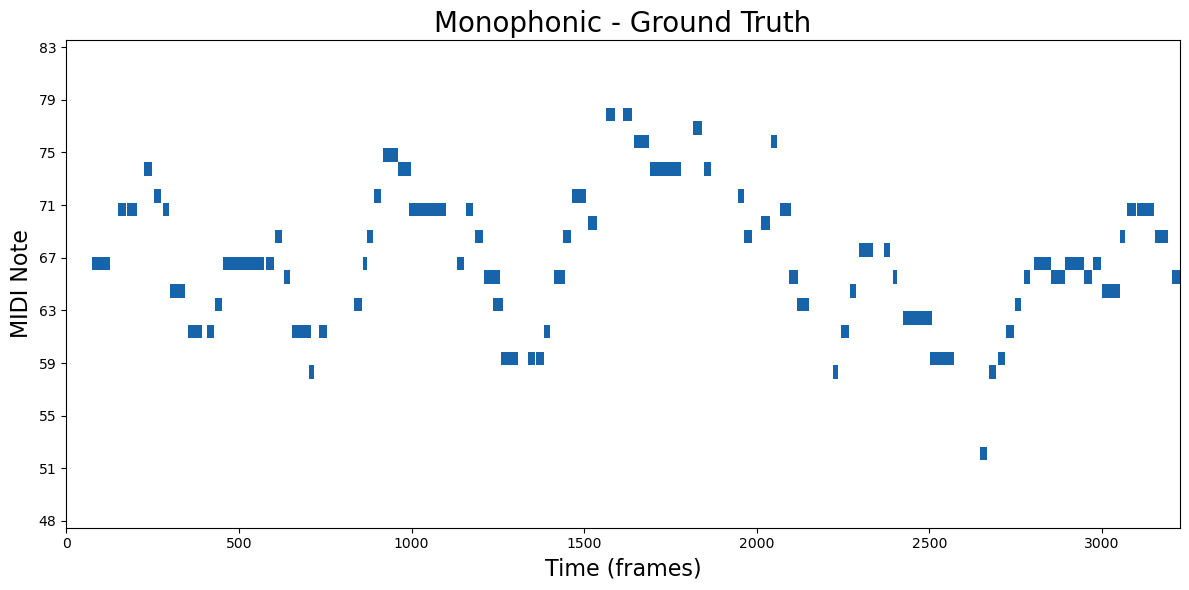

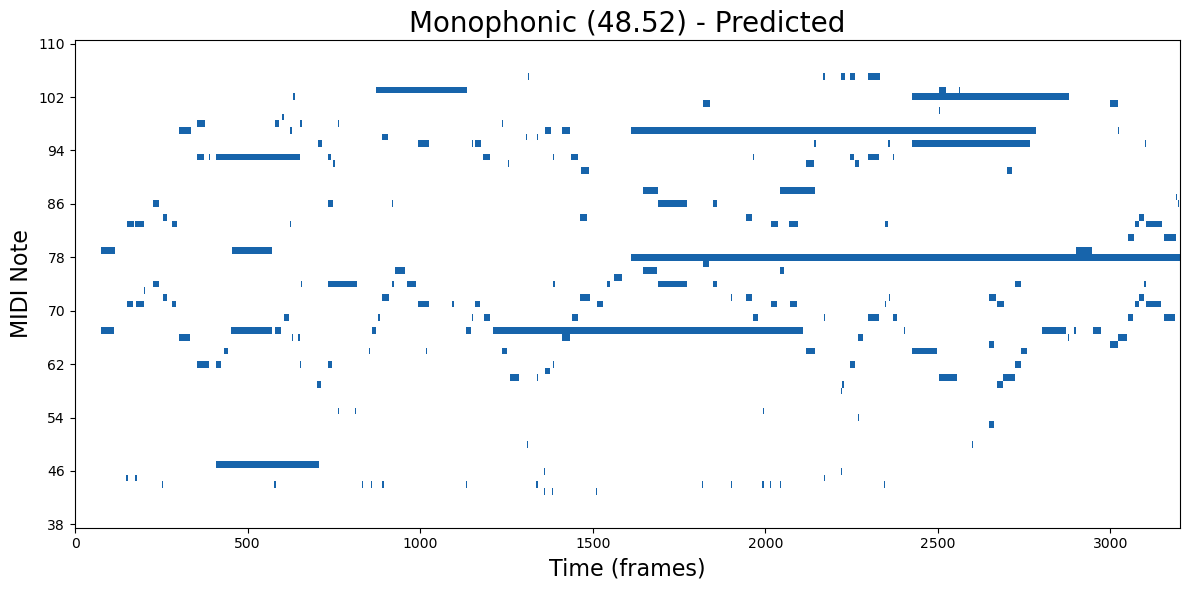

In [14]:
monophonic_file = "03_BN3-119-G_solo_mic" # An example recording with low polyohny

midi_path = GUITARSET_MIDI_PATH + "/" + monophonic_file + ".midi"
predicted_midi_path = "results/predicted_midi/" + monophonic_file + "_pred.midi"

monophonic_onset_f1 = f1_scores[monophonic_file].get('onset', 0)
monophonic_onset_offset_f1 = f1_scores[monophonic_file].get('onset_offset', 0)

print(f"Monophonic File: {monophonic_file}")
print(f"Onset F1: {monophonic_onset_f1}")
print(f"Onset & Offset F1: {monophonic_onset_offset_f1}")

# Plot piano roll for monophonic file
ground_truth_img = "results/piano_rolls/monophonic_ground_truth.png"
predicted_img = "results/piano_rolls/monophonic_predicted.png"

plot_piano_roll(midi_path, ground_truth_img, title='Monophonic - Ground Truth')
plot_piano_roll(predicted_midi_path, predicted_img, title=f'Monophonic ({monophonic_onset_f1 * 100}) - Predicted')

In [16]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_overlay_piano_roll(gt_path, pred_path, output_path, title='Overlayed Piano Roll', fs=100):
    gt_midi = pretty_midi.PrettyMIDI(gt_path)
    pred_midi = pretty_midi.PrettyMIDI(pred_path)

    gt_roll = gt_midi.get_piano_roll(fs=fs)
    pred_roll = pred_midi.get_piano_roll(fs=fs)

    gt_roll[gt_roll > 0] = 1
    pred_roll[pred_roll > 0] = 1

    # Align shapes
    max_len = max(gt_roll.shape[1], pred_roll.shape[1])
    gt_roll = np.pad(gt_roll, ((0, 0), (0, max_len - gt_roll.shape[1])), 'constant')
    pred_roll = np.pad(pred_roll, ((0, 0), (0, max_len - pred_roll.shape[1])), 'constant')

    # Overlay: 0=none, 1=GT only, 2=Pred only, 3=both
    overlay = gt_roll + 2 * pred_roll

    # Crop pitch range
    summed = (gt_roll + pred_roll).sum(axis=1)
    nonzero = np.where(summed > 0)[0]
    if len(nonzero) == 0:
        print("No notes to display.")
        return

    min_pitch = max(nonzero[0] - 5, 0)
    max_pitch = min(nonzero[-1] + 5, overlay.shape[0] - 1)
    overlay_crop = overlay[min_pitch:max_pitch + 1, :]

    # Custom colors
    blue = plt.get_cmap('Blues')(0.8)        # Predicted
    orange = [1.0, 0.5, 0.0, 1.0]             # Ground truth
    green = [0.0, 1.0, 0.0, 1.0]              # Overlap
    white = [1.0, 1.0, 1.0, 1.0]              # Background

    cmap = ListedColormap([white, orange, blue, green])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(overlay_crop, aspect='auto', origin='lower', cmap=cmap, interpolation='nearest')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Time (frames)', fontsize=16)
    ax.set_ylabel('MIDI Note', fontsize=16)

    yticks = np.linspace(0, max_pitch - min_pitch, 10)
    ytick_labels = np.linspace(min_pitch, max_pitch, 10, dtype=int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)

    # Legend
    legend_patches = [
        Patch(color=orange, label='Ground Truth'),
        Patch(color=blue, label='Predicted'),
        Patch(color=green, label='Overlap'),
    ]
    ax.legend(handles=legend_patches, loc='upper right')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


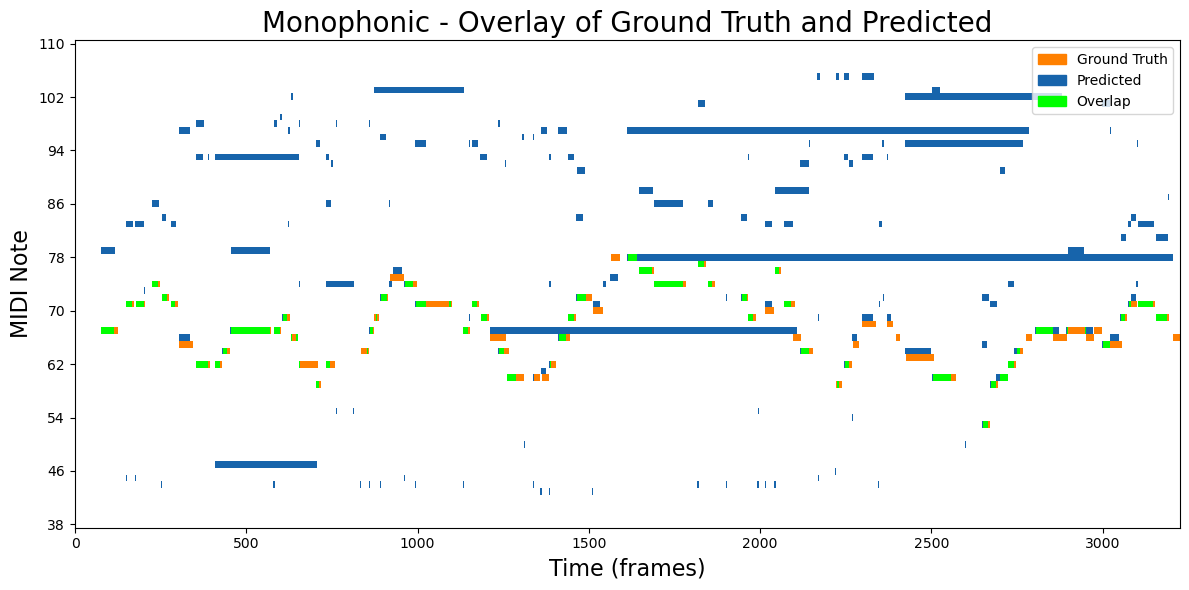

In [17]:

overlay_img = "results/piano_rolls/monophonic_overlay.png"
plot_overlay_piano_roll(midi_path, predicted_midi_path, overlay_img, title="Monophonic - Overlay of Ground Truth and Predicted")
